<a href="https://colab.research.google.com/github/Tommy-Las/WatfordFC/blob/main/ML_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages and data

In [85]:
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, make_scorer
from openpyxl import Workbook
from openpyxl.styles import PatternFill
from openpyxl.utils.dataframe import dataframe_to_rows
from collections import defaultdict
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.svm import SVC
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [86]:
file_path = 'data/cleaned_data_no_injured.xlsx'
#file_path = 'data/cleaned_data_no_injured_3.xlsx'
# Load the CSV into a DataFrame
df = pd.read_excel(file_path)

# Display the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4417 entries, 0 to 4416
Data columns (total 72 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DATE                       4417 non-null   datetime64[ns]
 1   Microcycle                 4219 non-null   object        
 2   Injury                     4417 non-null   int64         
 3   season                     4417 non-null   object        
 4   preseason-season           4417 non-null   object        
 5   TD                         4417 non-null   float64       
 6   >19.8                      4417 non-null   float64       
 7   >25                        4417 non-null   int64         
 8   ACC                        4417 non-null   float64       
 9   DEC                        4417 non-null   float64       
 10  PlayerID                   4417 non-null   int64         
 11  Max Speed                  4417 non-null   float64       
 12  Sprint

In [87]:
test = df[df['PlayerID'] == 37990].sort_values(by='DATE', ascending=False)
test.head()

,DATE,Microcycle,Injury,season,preseason-season,TD,>19.8,>25,ACC,DEC,...,>25_MSWR,ACC_ACWR,ACC_MSWR,DEC_ACWR,DEC_MSWR,Position_CENTREBACK,Position_CENTREMIDFIELDER,Position_FULLBACK,Position_STRIKER,Position_WINGER
2696,2023-05-07,M-1,0,2022-2023,SEASON,2239.0,35.0,0,36.0,17.0,...,0.542117,0.943069,1.015710,0.884311,1.019503,0,0,1,0,0
2695,2023-05-06,M-2,0,2022-2023,SEASON,4621.0,140.0,41,73.0,50.0,...,0.627062,0.986602,0.993061,1.023324,0.898798,0,0,1,0,0
2694,2023-05-05,M-3,0,2022-2023,SEASON,2863.0,111.0,10,40.0,30.0,...,0.597348,0.869888,0.816396,0.910162,0.753024,0,0,1,0,0
2693,2023-05-03,M-5,0,2022-2023,SEASON,4768.0,356.0,138,69.0,53.0,...,0.588090,1.031941,1.002824,1.004367,0.860458,0,0,1,0,0
2692,2023-05-02,M+3,0,2022-2023,SEASON,4732.0,145.0,4,72.0,53.0,...,0.635925,1.164420,1.002151,1.064669,0.850548,0,0,1,0,0


Class imbalance:

In [88]:
print("No Lesión: " + str(df[df["Injury"] == 0].shape[0]))
print("Lesión: " + str(df[df["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((df[df['Injury'] == 1].shape[0] / df.shape[0]) * 100):.2f}%")

No Lesión: 4381
Lesión: 36
Porcentaje de lesionados en el dataset: 0.82%


# Correlation of variables

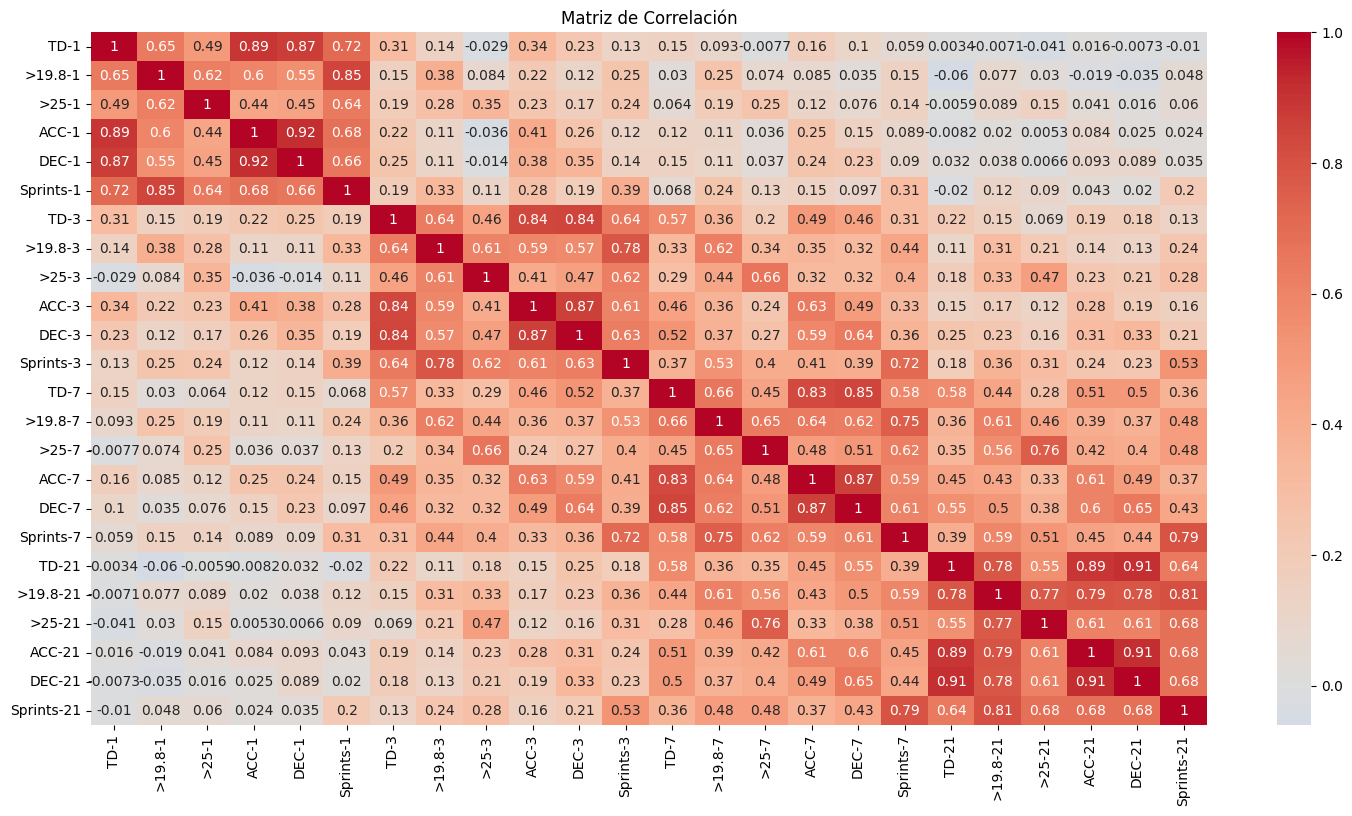

In [133]:
metrics = ['TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1',
       'Sprints-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3', 'DEC-3',
       'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7', 'DEC-7',
       'Sprints-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
       'DEC-21', 'Sprints-21']

# Calcular la matriz de correlación
correlation_matrix = df[metrics].corr()

# Mostrar la matriz de correlación
plt.figure(figsize=(18, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Matriz de Correlación")
plt.show()


In [134]:
df_with_constant = add_constant(df[metrics])

# Calcular el VIF para cada columna
vif_data = pd.DataFrame()
vif_data["Variable"] = df_with_constant.columns
vif_data["VIF"] = [variance_inflation_factor(df_with_constant.values, i)
                   for i in range(df_with_constant.shape[1])]

# Mostrar el VIF
print(vif_data)

      Variable        VIF
0        const  13.939388
1         TD-1   9.561094
2      >19.8-1   5.443764
3        >25-1   2.371835
4        ACC-1  13.282435
5        DEC-1  11.543172
6    Sprints-1   7.459849
7         TD-3  13.467069
8      >19.8-3   8.094323
9        >25-3   4.360377
10       ACC-3  15.121114
11       DEC-3  15.943716
12   Sprints-3  13.605974
13        TD-7  17.056307
14     >19.8-7  10.080486
15       >25-7   6.764550
16       ACC-7  20.170154
17       DEC-7  21.582907
18   Sprints-7  22.113711
19       TD-21  18.043957
20    >19.8-21  10.795460
21      >25-21   5.854916
22      ACC-21  19.845209
23      DEC-21  21.194680
24  Sprints-21  14.647902


# Filter data by date or season


In [94]:
# Season 2022-2023
df_filtered = df[df['season']=='2022-2023']

# Season 2021-2022
# df_filtered = df[df['season']=='2021-2022']

# Filter by no season
# df_filtered = df.copy()

df_filtered.head()

,DATE,Microcycle,Injury,season,preseason-season,TD,>19.8,>25,ACC,DEC,...,>25_MSWR,ACC_ACWR,ACC_MSWR,DEC_ACWR,DEC_MSWR,Position_CENTREBACK,Position_CENTREMIDFIELDER,Position_FULLBACK,Position_STRIKER,Position_WINGER
133,2022-06-21,NaN,0,2022-2023,PRESEASON,5511.0,113.0,6,68.0,35.0,...,0.377964,3.0,0.377964,3.0,0.377964,0,1,0,0,0
134,2022-06-22,NaN,0,2022-2023,PRESEASON,6553.0,27.0,0,96.0,34.0,...,0.447214,3.0,0.582392,3.0,0.561490,0,1,0,0,0
135,2022-06-23,NaN,0,2022-2023,PRESEASON,13058.0,267.0,17,90.0,63.0,...,0.447214,3.0,0.769055,3.0,0.771848,0,1,0,0,0
136,2022-06-24,NaN,0,2022-2023,PRESEASON,6716.0,232.0,33,75.0,45.0,...,0.537958,3.0,1.020528,3.0,0.911921,0,1,0,0,0
137,2022-06-25,NaN,0,2022-2023,PRESEASON,7723.0,241.0,45,54.0,46.0,...,0.646837,3.0,1.383708,3.0,1.221865,0,1,0,0,0


In [95]:
inj_2021 = df[(df['Injury'] == 1) & (df['season'] == '2021-2022')]
df_filtered = pd.concat([df_filtered, inj_2021])

In [96]:
df_filtered = df_filtered[df_filtered['preseason-season'] != 'PRESEASON']

df_filtered.reset_index(drop=True, inplace=True)

In [97]:
print("No Lesión: " + str(df_filtered[df_filtered["Injury"] == 0].shape[0]))
print("Lesión: " + str(df_filtered[df_filtered["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((df_filtered[df_filtered['Injury'] == 1].shape[0] / df_filtered.shape[0]) * 100):.2f}%")

No Lesión: 2285
Lesión: 35
Porcentaje de lesionados en el dataset: 1.51%


# ML Models

## Separate data into X, y and player_ids

In [98]:
df_filtered.columns

Index(['DATE', 'Microcycle', 'Injury', 'season', 'preseason-season', 'TD',
       '>19.8', '>25', 'ACC', 'DEC', 'PlayerID', 'Max Speed', 'Sprints',
       'Mins', 'Max Speed Season', 'Avg Speed Season', '% Max Speed',
       'Speed Diff Max Avg', 'TD_Rel', '>19.8_Rel', '>25_Rel', 'ACC_Rel',
       'DEC_Rel', 'TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1', 'Sprints-1',
       'Mins-1', 'TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', 'ACC_Rel-1',
       'DEC_Rel-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
       'DEC-3', 'Sprints-3', 'Mins-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
       'DEC-7', 'Sprints-7', 'Mins-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
       'DEC-21', 'Sprints-21', 'Mins-21', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR',
       '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR',
       'DEC_ACWR', 'DEC_MSWR', 'Position_CENTREBACK',
       'Position_CENTREMIDFIELDER', 'Position_FULLBACK', 'Position_STRIKER',
       'Position_WINGER'],
      dtype='object')

Initialize the features we want to train

In [99]:
metrics_train = ['Injury','TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1', 'Sprints-1',
       'Mins-1', 'TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', 'ACC_Rel-1',
       'DEC_Rel-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
       'DEC-3', 'Sprints-3', 'Mins-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
       'DEC-7', 'Sprints-7', 'Mins-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
       'DEC-21', 'Sprints-21', 'Mins-21', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR',
       '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR',
       'DEC_ACWR', 'DEC_MSWR']

print(len(metrics_train))

45


Sort the df by date

In [100]:
df_sorted = df_filtered.sort_values(by='DATE', ascending=False).reset_index(drop=True)

## Split data

We want to also store the 'DATE' & 'PlayerID' columns for later comparison

### Split by selecting 10 first injuries and its past 30 days

In [33]:
extra_cols = df_sorted[['DATE', 'PlayerID']]
X = df_sorted[metrics_train]
y = df_sorted['Injury']

In [34]:
print("No Lesión: " + str(X[X["Injury"] == 0].shape[0]))
print("Lesión: " + str(X[X["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((X[X['Injury'] == 1].shape[0] / X.shape[0]) * 100):.2f}%")

No Lesión: 2285
Lesión: 23
Porcentaje de lesionados en el dataset: 1.00%


In [35]:
# Parameter: Number of injuries for the test set
num_test_injuries = 7  # Number of injuries to include in the test set

# Step 1: Identify rows where `Injury` occurred (Injury == 1)
injury_rows = df_sorted[df_sorted['Injury'] == 1]

# Step 2: Select the first `num_test_injuries` injuries for the test set
test_injury_indices = injury_rows.index[:num_test_injuries]

# Step 3: Collect past 30 days of data for each test injury
test_indices = set()

days_before_test = 20
days_before_train = 50

for idx in test_injury_indices:
    injury_date = df_sorted.loc[idx, 'DATE']
    player_id = df_sorted.loc[idx, 'PlayerID']
    # Collect all rows for this player in the past 30 days
    past_30_days_indices = df_sorted[
        (df_sorted['PlayerID'] == player_id) &
        (df_sorted['DATE'] <= injury_date) &
        (df_sorted['DATE'] > injury_date - pd.Timedelta(days=days_before_test))
    ].index
    test_indices.update(past_30_days_indices)

# Step 4: Select the remaining injuries for the training set
remaining_injury_indices = injury_rows.index.difference(test_injury_indices)

train_indices = set()

for idx in remaining_injury_indices:
    injury_date = df_sorted.loc[idx, 'DATE']
    player_id = df_sorted.loc[idx, 'PlayerID']
    # Collect all rows for this player in the past 30 days, excluding test indices
    past_30_days_indices = df_sorted[
        (df_sorted['PlayerID'] == player_id) &
        (df_sorted['DATE'] <= injury_date) &
        (df_sorted['DATE'] > injury_date - pd.Timedelta(days=days_before_train))
    ].index
    train_indices.update(set(past_30_days_indices).difference(test_indices))

# Convert to lists
test_indices = list(test_indices)
train_indices = list(train_indices)

# Step 5: Create training and test sets
X_test = X.loc[test_indices]
y_test = y.loc[test_indices]

X_train = X.loc[train_indices]
y_train = y.loc[train_indices]

# Optional: Extra columns for test and training sets
extra_cols_test = extra_cols.loc[test_indices]
extra_cols_train = extra_cols.loc[train_indices]

# Sanity check for dataset sizes
print(f"Number of rows in test set: {len(X_test)}")
print(f"Number of rows in training set: {len(X_train)}")


Number of rows in test set: 96
Number of rows in training set: 472


In [36]:
print("No Lesión: " + str(X_train[X_train["Injury"] == 0].shape[0]))
print("Lesión: " + str(X_train[X_train["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((X_train[X_train['Injury'] == 1].shape[0] / X_train.shape[0]) * 100):.2f}%")

No Lesión: 456
Lesión: 16
Porcentaje de lesionados en el dataset: 3.39%


In [37]:
print("No Lesión: " + str(X_test[X_test["Injury"] == 0].shape[0]))
print("Lesión: " + str(X_test[X_test["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((X_test[X_test['Injury'] == 1].shape[0] / X_test.shape[0]) * 100):.2f}%")

No Lesión: 89
Lesión: 7
Porcentaje de lesionados en el dataset: 7.29%


In [38]:
X_train.drop(columns=['Injury'], inplace=True)
X_test.drop(columns=['Injury'], inplace=True)

### Split by first %X for validating and rest for training

In [116]:
extra_cols = df_sorted[['DATE', 'PlayerID']]
X = df_sorted[metrics_train]
y = df_sorted['Injury']

# Determine the split index for X% testing
percentage_validation = 0.3
split_index = int(percentage_validation * len(df_sorted))

# Split the data
X_test = X.iloc[:split_index].reset_index(drop=True)
X_train = X.iloc[split_index:].reset_index(drop=True)
y_test = y.iloc[:split_index].reset_index(drop=True)
y_train = y.iloc[split_index:].reset_index(drop=True)
extra_cols_test = extra_cols.iloc[:split_index].reset_index(drop=True)
extra_cols_train = extra_cols.iloc[split_index:].reset_index(drop=True)

Select less amount of data

In [117]:
print("No Lesión: " + str(X_train[X_train["Injury"] == 0].shape[0]))
print("Lesión: " + str(X_train[X_train["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((X_train[X_train['Injury'] == 1].shape[0] / X_train.shape[0]) * 100):.2f}%")

No Lesión: 1599
Lesión: 20
Porcentaje de lesionados en el dataset: 1.24%


In [118]:
# Sort X_train by index
X_train = X_train.sort_index()  # Sort by date or relevant index if not already sorted.
y_train = y_train.sort_index()  # Ensure y_train matches X_train in order.

# Filter rows where 'Injury' == 1
injury_rows = X_train[X_train['Injury'] == 1]

# Get 30 days before each injury
# Assuming a datetime index, otherwise adjust for your date representation
indices_to_include = set(injury_rows.index)

for idx in injury_rows.index:
    # Include 30 rows before the 'Injury == 1', ensure not out of bounds
    start_idx = max(0, idx - 30)
    indices_to_include.update(range(start_idx, idx + 1))

# Create a dataframe with required rows (Injury == 1 and 30 days before)
selected_rows = X_train.loc[list(indices_to_include)]
selected_y = y_train.loc[selected_rows.index]  # Match y_train with selected rows

# Get the remaining rows not in `selected_rows`
remaining_rows = X_train.drop(selected_rows.index)
remaining_y = y_train.drop(selected_y.index)

# Proportion for sampling (e.g., 50%)
sample_proportion = 0.5
n_to_sample = int(len(X_train) * sample_proportion - len(selected_rows))

# Randomly sample from the remaining rows
sampled_rows = remaining_rows.sample(n=n_to_sample, random_state=42)
sampled_y = remaining_y.loc[sampled_rows.index]

# Combine the selected rows and sampled rows
X_train = pd.concat([selected_rows, sampled_rows]).sort_index().reset_index(drop=True)
y_train = pd.concat([selected_y, sampled_y]).sort_index().reset_index(drop=True)


In [119]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809 entries, 0 to 808
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Injury      809 non-null    int64  
 1   TD-1        809 non-null    float64
 2   >19.8-1     809 non-null    int64  
 3   >25-1       809 non-null    int64  
 4   ACC-1       809 non-null    float64
 5   DEC-1       809 non-null    float64
 6   Sprints-1   809 non-null    int64  
 7   TD-3        809 non-null    float64
 8   >19.8-3     809 non-null    float64
 9   >25-3       809 non-null    int64  
 10  ACC-3       809 non-null    float64
 11  DEC-3       809 non-null    float64
 12  Sprints-3   809 non-null    int64  
 13  TD-7        809 non-null    float64
 14  >19.8-7     809 non-null    float64
 15  >25-7       809 non-null    int64  
 16  ACC-7       809 non-null    float64
 17  DEC-7       809 non-null    float64
 18  Sprints-7   809 non-null    int64  
 19  TD-21       809 non-null    f

In [120]:
print("No Lesión: " + str(X_train[X_train["Injury"] == 0].shape[0]))
print("Lesión: " + str(X_train[X_train["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((X_train[X_train['Injury'] == 1].shape[0] / X_train.shape[0]) * 100):.2f}%")

No Lesión: 789
Lesión: 20
Porcentaje de lesionados en el dataset: 2.47%


In [156]:
X_train.drop(columns=['Injury'], inplace=True)
X_test.drop(columns=['Injury'], inplace=True)

### Split random 

In [47]:
extra_cols = df_sorted[['DATE', 'PlayerID']]
X = df_sorted[metrics_train]
y = df_sorted['Injury']

# Split the data into training and test sets
# X_train, X_test, y_train, y_test, extra_cols_train, extra_cols_test = train_test_split(X, y, extra_cols, test_size=0.3, random_state=42, stratify=y)
X_train, X_test, y_train, y_test, extra_cols_train, extra_cols_test = train_test_split(X, y, extra_cols, test_size=0.3, random_state=42, stratify=y)

X_train.drop(columns=['Injury'], inplace=True)
X_test.drop(columns=['Injury'], inplace=True)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
extra_cols_train.reset_index(drop=True, inplace=True)
extra_cols_test.reset_index(drop=True, inplace=True)


## SMOTE or SMOTEEN oversampling technique

In [101]:
# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train , y_train = smote.fit_resample(X_train, y_train)

# Apply SMOTEEN to training data
# smote_enn = SMOTEENN(random_state=42)
# X_train, y_train = smote_enn.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train).value_counts())
print(pd.Series(y_train).value_counts())

Class distribution after SMOTE:
Injury
0    1599
1    1599
Name: count, dtype: int64
Injury
0    1599
1    1599
Name: count, dtype: int64


## Logistic Regression

Initialize logistic regression and normalize the data

In [20]:
# Create the model
logistic_model = LogisticRegression(random_state=42, max_iter=1000)

# Initialize the scaler
scaler = StandardScaler()

# Scale only metrics_numeric columns
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Logistic Regression Active learning 

to dynamically select data

In [19]:
# Initialize datasets
X_all = X_train_scaled  # Scaled features
y_all = y_train.values  # Labels

# Start with a small labeled dataset from the bottom of the sorted DataFrame
initial_samples = 50  # Number of initial samples
X_train_active = X_all[-initial_samples:]  # Select the last `initial_samples` rows
y_train_active = y_all[-initial_samples:]  # Corresponding labels

# Remaining unlabeled pool (everything except the selected rows)
X_pool = X_all[:-initial_samples]
y_pool = y_all[:-initial_samples]

print(f"Initial training set size: {len(X_train_active)}")
print(f"Remaining pool size: {len(X_pool)}")

Initial training set size: 50
Remaining pool size: 3148


Iteration 1/250:
Training Recall for Label 1: 0.0000
Training Size: 55
Iteration 2/250:
Training Recall for Label 1: 0.0000
Training Size: 60
Iteration 3/250:
Training Recall for Label 1: 0.0000
Training Size: 65
Iteration 4/250:
Training Recall for Label 1: 0.0000
Training Size: 70
Iteration 5/250:
Training Recall for Label 1: 0.0000
Training Size: 75
Iteration 6/250:
Training Recall for Label 1: 0.0000
Training Size: 80
Iteration 7/250:
Training Recall for Label 1: 0.0000
Training Size: 85
Iteration 8/250:
Training Recall for Label 1: 0.0000
Training Size: 90
Iteration 9/250:
Training Recall for Label 1: 0.0000
Training Size: 95
Iteration 10/250:
Training Recall for Label 1: 0.0000
Training Size: 100
Iteration 11/250:
Training Recall for Label 1: 0.0000
Training Size: 105
Iteration 12/250:
Training Recall for Label 1: 0.0000
Training Size: 110
Iteration 13/250:
Training Recall for Label 1: 0.0000
Training Size: 115
Iteration 14/250:
Training Recall for Label 1: 0.0000
Training Size: 

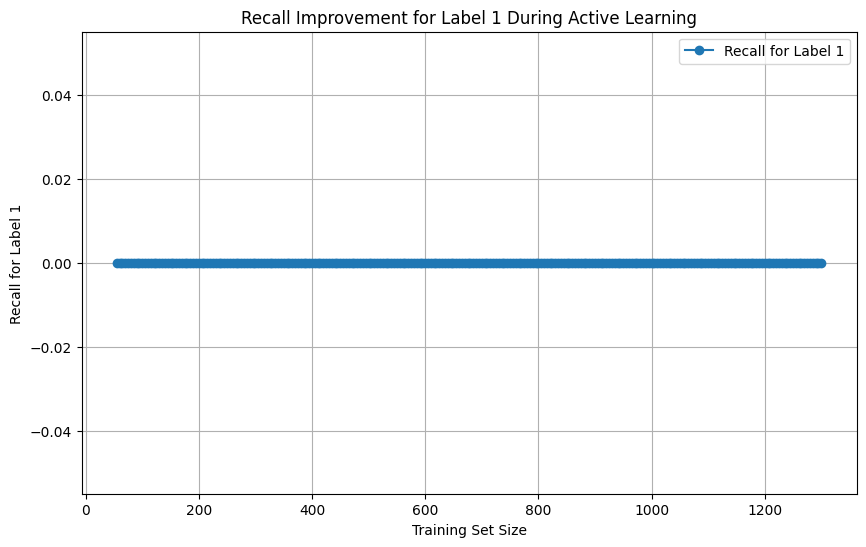

In [31]:
# Parameters for active learning
n_iterations = 250  # Number of active learning iterations
samples_per_iteration = 5  # Samples to add in each iteration

# To store metrics for visualization
train_recall_label1_scores = []
train_sizes = []

for i in range(n_iterations):
    # Train the model on the current labeled dataset
    logistic_model.fit(X_train_active, y_train_active)
    
    # Predict probabilities for the unlabeled pool
    probs = logistic_model.predict_proba(X_pool)[:, 1]
    
    # Find the most uncertain samples (probabilities closest to 0.5)
    uncertainty = np.abs(probs - 0.5)  # Uncertainty measure
    uncertain_indices = np.argsort(uncertainty)[:samples_per_iteration]
    
    # Add the most uncertain samples to the training set
    X_train_active = np.vstack((X_train_active, X_pool[uncertain_indices]))
    y_train_active = np.hstack((y_train_active, y_pool[uncertain_indices]))
    
    # Remove these samples from the pool
    X_pool = np.delete(X_pool, uncertain_indices, axis=0)
    y_pool = np.delete(y_pool, uncertain_indices, axis=0)
    
    # Evaluate recall for label 1
    y_train_pred = logistic_model.predict(X_train_active)
    recall_label1 = recall_score(y_train_active, y_train_pred, pos_label=1)  # Focus on label 1
    train_recall_label1_scores.append(recall_label1)
    train_sizes.append(len(y_train_active))
    
    print(f"Iteration {i + 1}/{n_iterations}:")
    print(f"Training Recall for Label 1: {recall_label1:.4f}")
    print(f"Training Size: {len(y_train_active)}")
    
    
# Plot recall improvement for label 1
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_recall_label1_scores, marker='o', label="Recall for Label 1")
plt.xlabel("Training Set Size")
plt.ylabel("Recall for Label 1")
plt.title("Recall Improvement for Label 1 During Active Learning")
plt.legend()
plt.grid()
plt.show()

In [65]:
# Evaluate on test data
y_test_pred = logistic_model.predict(X_test_scaled)
print("\nTest Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))



Test Set Evaluation:
Accuracy: 0.8371757925072046
Confusion Matrix:
 [[579 108]
 [  5   2]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91       687
           1       0.02      0.29      0.03         7

    accuracy                           0.84       694
   macro avg       0.50      0.56      0.47       694
weighted avg       0.98      0.84      0.90       694



### Regular logistic regression

In [21]:
# Train the model
logistic_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = logistic_model.predict(X_train_scaled)
y_test_pred = logistic_model.predict(X_test_scaled)

# Probabilities
y_test_probs = logistic_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for the positive class

# Training evaluation
print("Training Set Evaluation:")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("Classification Report:\n", classification_report(y_train, y_train_pred))

# Test evaluation
print("\nTest Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Training Set Evaluation:
Accuracy: 0.9337085678549093
Confusion Matrix:
 [[1387  212]
 [   0 1599]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.87      0.93      1599
           1       0.88      1.00      0.94      1599

    accuracy                           0.93      3198
   macro avg       0.94      0.93      0.93      3198
weighted avg       0.94      0.93      0.93      3198


Test Set Evaluation:
Accuracy: 0.8744588744588745
Confusion Matrix:
 [[604  82]
 [  5   2]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.88      0.93       686
           1       0.02      0.29      0.04         7

    accuracy                           0.87       693
   macro avg       0.51      0.58      0.49       693
weighted avg       0.98      0.87      0.92       693



Find the best threshold

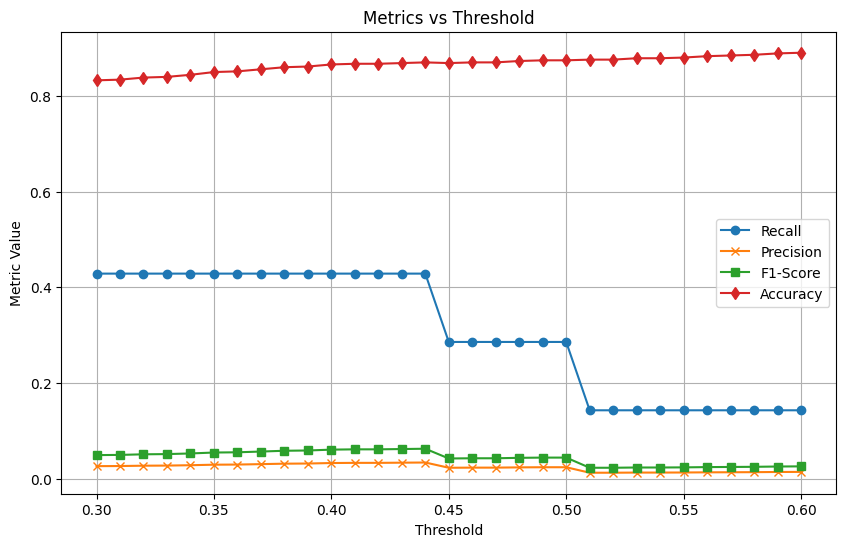

In [22]:
# Thresholds to evaluate (from 0.3 to 0.6 in steps of 0.01)
thresholds = np.arange(0.3, 0.61, 0.01)  # Thresholds from 0 to 1 in steps of 0.01

# Store results
results = []

for threshold in thresholds:
    # Generate predictions for the current threshold
    y_pred = (y_test_probs >= threshold).astype(int)
    
    # Calculate metrics
    recall = recall_score(y_test, y_pred, pos_label=1)  # Recall for label 1
    precision = precision_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append metrics and threshold to results
    results.append({
        'Threshold': threshold,
        'Recall': recall,
        'Precision': precision,
        'F1-Score': f1,
        'Accuracy': accuracy
    })
    
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Recall'], label='Recall', marker='o')
plt.plot(results_df['Threshold'], results_df['Precision'], label='Precision', marker='x')
plt.plot(results_df['Threshold'], results_df['F1-Score'], label='F1-Score', marker='s')
plt.plot(results_df['Threshold'], results_df['Accuracy'], label='Accuracy', marker='d')
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Metrics vs Threshold")
plt.legend()
plt.grid()
plt.show()

ROC Curve with manually selecting the threshold

Number of unique thresholds: 17

Manually Selected Threshold: 0.44

Evaluation with Manually Selected Threshold:
Accuracy: 0.8701298701298701
Confusion Matrix:
 [[600  86]
 [  4   3]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.87      0.93       686
           1       0.03      0.43      0.06         7

    accuracy                           0.87       693
   macro avg       0.51      0.65      0.50       693
weighted avg       0.98      0.87      0.92       693



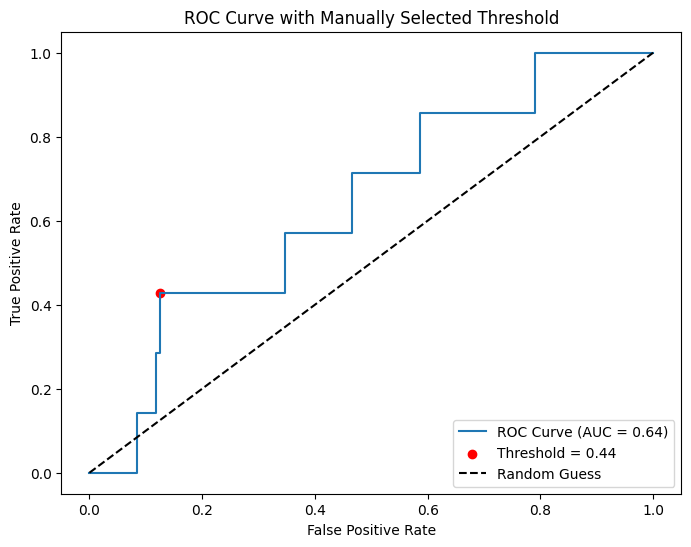

In [23]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
roc_auc = auc(fpr, tpr)

# Print the number of unique thresholds
print(f"Number of unique thresholds: {len(thresholds)}")

# Manually select the threshold
manual_threshold = 0.44 # Manually chosen threshold
print(f"\nManually Selected Threshold: {manual_threshold:.2f}")

# Apply the manually selected threshold
y_test_pred_manual = (y_test_probs >= manual_threshold).astype(int)

# Evaluate the model with the manually selected threshold
print("\nEvaluation with Manually Selected Threshold:")
print("Accuracy:", accuracy_score(y_test, y_test_pred_manual))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_manual))
print("Classification Report:\n", classification_report(y_test, y_test_pred_manual))

# Find the index of the manually selected threshold in the ROC data
# Using `thresholds` from the ROC calculation
manual_idx = np.argmin(np.abs(thresholds - manual_threshold))

# Plot the ROC curve and mark the manually selected threshold
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.scatter(fpr[manual_idx], tpr[manual_idx], color="red", label=f"Threshold = {manual_threshold:.2f}")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Manually Selected Threshold")
plt.legend(loc="lower right")
plt.show()

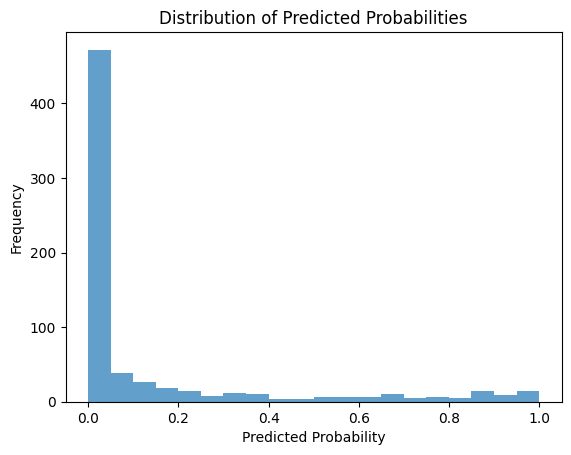

In [24]:
plt.hist(y_test_probs, bins=20, alpha=0.7)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

Store the coeficients

In [25]:
# Reset index for consistency
extra_cols_test.reset_index(inplace=True, drop=True)

# Get coefficients and intercept
coefficients = logistic_model.coef_[0]  # Coefficients
intercept = logistic_model.intercept_[0]  # Intercept
features = X_test.columns  # Feature names

# Create the player-score DataFrame
df_a = pd.DataFrame({
    'Player': extra_cols_test['PlayerID'],
    'Date': extra_cols_test['DATE'],
    'Score': y_test_probs,
    'Actual': y_test.reset_index(drop=True)
})

# Add feature values and calculate z (linear combination)
for i, feature in enumerate(features):
    df_a[feature] = X_test_scaled[:, i]  # Add scaled feature values
    df_a[f'Coeff_{feature}'] = coefficients[i]  # Add coefficient for each feature

# Calculate the linear combination (z) for each row
df_a['Linear_Combination'] = (
    np.dot(X_test_scaled, coefficients) + intercept
)

# Display the resulting DataFrame
print("\nPlayer, Date, Feature Contributions, Linear Combination, and Score DataFrame:")
df_a.head()



Player, Date, Feature Contributions, Linear Combination, and Score DataFrame:


,Player,Date,Score,Actual,TD-1,Coeff_TD-1,>19.8-1,Coeff_>19.8-1,>25-1,Coeff_>25-1,...,Coeff_>25_MSWR,ACC_ACWR,Coeff_ACC_ACWR,ACC_MSWR,Coeff_ACC_MSWR,DEC_ACWR,Coeff_DEC_ACWR,DEC_MSWR,Coeff_DEC_MSWR,Linear_Combination
0,26485,2023-04-21,2.180123e-02,0,-1.715134,-3.503378,-0.679097,-1.621229,-0.366642,-1.241571,...,1.055769,-0.406972,-1.261751,-0.342588,-0.949085,-0.025781,0.238714,-0.958036,3.776927,-3.803747
1,12086,2022-12-09,1.172715e-03,0,-1.715134,-3.503378,-0.679097,-1.621229,-0.366642,-1.241571,...,1.055769,2.300778,-1.261751,0.179012,-0.949085,2.783257,0.238714,0.808959,3.776927,-6.747260
2,26485,2023-02-19,1.209787e-03,0,1.005555,-3.503378,0.993782,-1.621229,0.742085,-1.241571,...,1.055769,-0.398546,-1.261751,-0.394478,-0.949085,-0.356971,0.238714,-1.103496,3.776927,-6.716100
3,25467,2023-03-05,3.601851e-14,0,1.188933,-3.503378,4.944624,-1.621229,13.023365,-1.241571,...,1.055769,0.489692,-1.261751,0.197867,-0.949085,0.528389,0.238714,0.664530,3.776927,-30.954744
4,48692,2022-08-25,1.244980e-04,0,0.507144,-3.503378,0.495477,-1.621229,-0.281355,-1.241571,...,1.055769,-0.945363,-1.261751,-0.169662,-0.949085,-0.820378,0.238714,-0.771072,3.776927,-8.991097


Find the features that affect the injuries the most

In [26]:
# Assuming your features are in a DataFrame
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,  # Replace with your feature names
    "Importance": logistic_model.coef_[0]  # Coefficients from logistic regression
})

# Sort by importance
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# Display the feature importance
print(feature_importance)

          Feature  Importance
13           TD-3    4.406540
4           DEC-1    3.938267
43       DEC_MSWR    3.776927
12  % Max Speed-1    3.279537
7        TD_Rel-1    3.097026
29         >25-21    3.093050
27          TD-21    2.026838
38       >25_ACWR    1.662172
31         DEC-21    1.576796
25      Sprints-7    1.472420
39       >25_MSWR    1.055769
24          DEC-7    1.049102
34        TD_ACWR    0.924627
30         ACC-21    0.767614
16          ACC-3    0.561595
21        >19.8-7    0.310133
8     >19.8_Rel-1    0.259451
42       DEC_ACWR    0.238714
23          ACC-7    0.027799
26         Mins-7   -0.183513
6          Mins-1   -0.206550
15          >25-3   -0.230213
10      ACC_Rel-1   -0.277451
36     >19.8_ACWR   -0.525227
5       Sprints-1   -0.647157
20           TD-7   -0.773972
14        >19.8-3   -0.891258
19         Mins-3   -0.894500
41       ACC_MSWR   -0.949085
18      Sprints-3   -0.995627
32     Sprints-21   -1.092603
9       >25_Rel-1   -1.128544
3         

Select X quantity of the top features and retrain the model

In [31]:
# Extract top features by absolute importance
num_top_features =  26 # Adjust this to include the number of features you want
top_features = feature_importance.iloc[:num_top_features]["Feature"].values

print(f"Selected Top {num_top_features} Features: {top_features}")

Selected Top 26 Features: ['TD-3' 'DEC-1' 'DEC_MSWR' '% Max Speed-1' 'TD_Rel-1' '>25-21' 'TD-21'
 '>25_ACWR' 'DEC-21' 'Sprints-7' '>25_MSWR' 'DEC-7' 'TD_ACWR' 'ACC-21'
 'ACC-3' '>19.8-7' '>19.8_Rel-1' 'DEC_ACWR' 'ACC-7' 'Mins-7' 'Mins-1'
 '>25-3' 'ACC_Rel-1' '>19.8_ACWR' 'Sprints-1' 'TD-7']


Updated Model Evaluation:
Accuracy: 0.8080808080808081
Confusion Matrix:
 [[559 127]
 [  6   1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.81      0.89       686
           1       0.01      0.14      0.01         7

    accuracy                           0.81       693
   macro avg       0.50      0.48      0.45       693
weighted avg       0.98      0.81      0.88       693



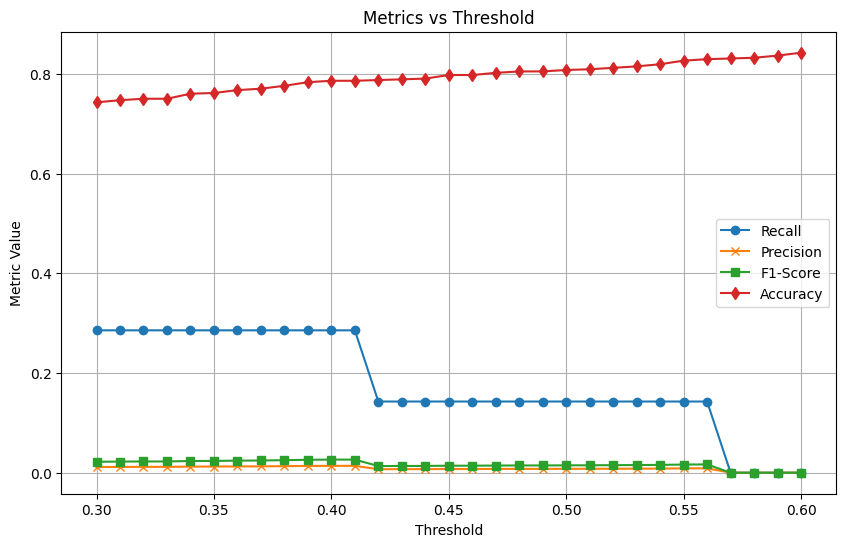

In [32]:
# Filter the training and testing data for top features
X_train_top = X_train_scaled[:, [X_train.columns.get_loc(f) for f in top_features]]
X_test_top = X_test_scaled[:, [X_train.columns.get_loc(f) for f in top_features]]

# Train logistic regression with top features
logistic_model_top = LogisticRegression(random_state=42, max_iter=1000)
logistic_model_top.fit(X_train_top, y_train)

# Predictions
y_test_pred_top = logistic_model_top.predict(X_test_top)
y_test_probs_top = logistic_model_top.predict_proba(X_test_top)[:, 1]

# Evaluate performance
print("Updated Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_test_pred_top))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_top))
print("Classification Report:\n", classification_report(y_test, y_test_pred_top))

# Thresholds to evaluate (from 0.3 to 0.6 in steps of 0.01)
thresholds = np.arange(0.3, 0.61, 0.01)  # Thresholds from 0 to 1 in steps of 0.01

# Store results
results = []

for threshold in thresholds:
    # Generate predictions for the current threshold
    y_pred = (y_test_probs_top >= threshold).astype(int)
    
    # Calculate metrics
    recall = recall_score(y_test, y_pred, pos_label=1)  # Recall for label 1
    precision = precision_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append metrics and threshold to results
    results.append({
        'Threshold': threshold,
        'Recall': recall,
        'Precision': precision,
        'F1-Score': f1,
        'Accuracy': accuracy
    })
    
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Recall'], label='Recall', marker='o')
plt.plot(results_df['Threshold'], results_df['Precision'], label='Precision', marker='x')
plt.plot(results_df['Threshold'], results_df['F1-Score'], label='F1-Score', marker='s')
plt.plot(results_df['Threshold'], results_df['Accuracy'], label='Accuracy', marker='d')
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Metrics vs Threshold")
plt.legend()
plt.grid()
plt.show()

Number of unique thresholds: 17

Manually Selected Threshold: 0.55

Evaluation with Manually Selected Threshold:
Accuracy: 0.7936507936507936
Confusion Matrix:
 [[550 136]
 [  7   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.80      0.88       686
           1       0.00      0.00      0.00         7

    accuracy                           0.79       693
   macro avg       0.49      0.40      0.44       693
weighted avg       0.98      0.79      0.88       693



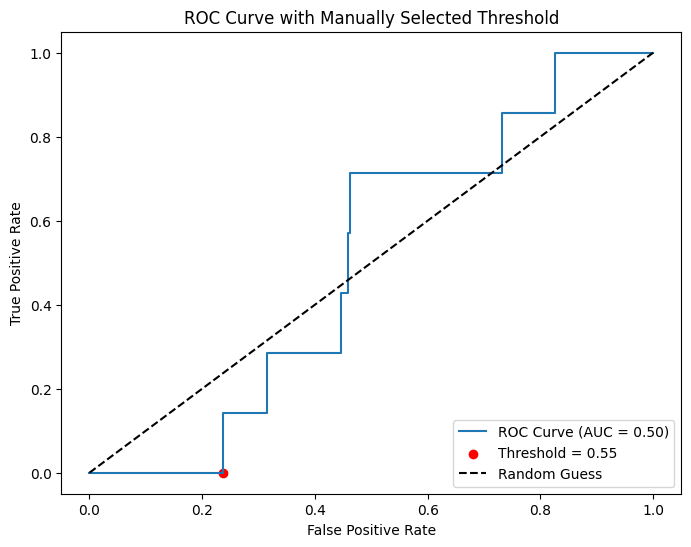

In [24]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs_top)
roc_auc = auc(fpr, tpr)

# Print the number of unique thresholds
print(f"Number of unique thresholds: {len(thresholds)}")

# Manually select the threshold
manual_threshold = 0.55  # Manually chosen threshold
print(f"\nManually Selected Threshold: {manual_threshold:.2f}")

# Apply the manually selected threshold
y_test_pred_manual = (y_test_probs_top >= manual_threshold).astype(int)

# Evaluate the model with the manually selected threshold
print("\nEvaluation with Manually Selected Threshold:")
print("Accuracy:", accuracy_score(y_test, y_test_pred_manual))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_manual))
print("Classification Report:\n", classification_report(y_test, y_test_pred_manual))

# Find the index of the manually selected threshold in the ROC data
# Using `thresholds` from the ROC calculation
manual_idx = np.argmin(np.abs(thresholds - manual_threshold))

# Plot the ROC curve and mark the manually selected threshold
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.scatter(fpr[manual_idx], tpr[manual_idx], color="red", label=f"Threshold = {manual_threshold:.2f}")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Manually Selected Threshold")
plt.legend(loc="lower right")
plt.show()

## ANN

In [119]:
metrics_ANN = ['Sprints-7', 'TD-3', '>25-21', 'ACC-7', 'TD-1', '>19.8-21', 'DEC-1', 'DEC-3', 'ACC-21', '>25-7']
metrics_ANN = metrics_train

In [136]:
# Initialize the scaler
scaler = StandardScaler()

# X_train_selected = X_train[metrics_ANN]
# X_test_selected = X_test[metrics_ANN]

X_train_selected = X_train
X_test_selected = X_test

# Scale only metrics_numeric columns
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Define the ANN model with regularization
def create_ann(input_dim):
    model = Sequential()
    # Input layer and first hidden layer with L2 regularization
    model.add(Dense(units=64, activation='relu', input_dim=input_dim, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    
    # Second hidden layer with L2 regularization
    model.add(Dense(units=32, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))

    model.add(Dense(units=32, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    
    # Output layer (for classification with probabilities)
    model.add(Dense(units=1, activation='sigmoid'))  # Using 'sigmoid' for binary classification

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Example usage:
# Assuming X_train_scaled, X_test_scaled, y_train, and y_test are your datasets
# Replace the input_dim with the number of features in your dataset
input_dim = X_train_scaled.shape[1]

# Create the model
model = create_ann(input_dim)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

class_weight = {0: 1.0, 1: 10.0}
history = model.fit(
    X_train_scaled, 
    y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.2, 
    verbose=1, 
    callbacks=[early_stopping, lr_scheduler],
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Loss: {loss}, Accuracy: {accuracy}")

# Get probabilities for the test set as percentages
probabilities = model.predict(X_test_scaled)
probabilities_percentage = probabilities * 100

/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6153 - loss: 1.7589 - val_accuracy: 0.5484 - val_loss: 1.5566 - learning_rate: 0.0010
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7794 - loss: 1.2307 - val_accuracy: 0.8703 - val_loss: 1.0686 - learning_rate: 0.0010
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8749 - loss: 0.8712 - val_accuracy: 0.9719 - val_loss: 0.7551 - learning_rate: 0.0010
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9221 - loss: 0.6288 - val_accuracy: 0.9906 - val_loss: 0.5928 - learning_rate: 0.0010
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9590 - loss: 0.4719 - val_accuracy: 1.0000 - val_loss: 0.3957 - learning_rate: 0.0010
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9696 - loss: 0.3751 - val_accuracy: 1.0000 - val_loss: 0.3324 - learning_rate: 0.0010
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9828 - loss: 0.3000 - val_ac

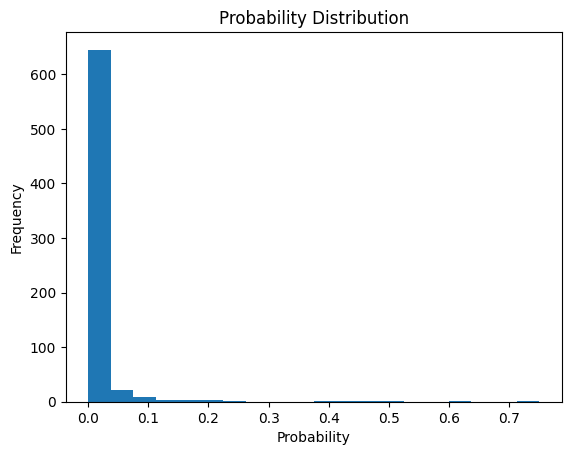

In [137]:
plt.hist(probabilities, bins=20)
plt.title("Probability Distribution")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.show()

In [138]:
# Get predictions (rounded to 0 or 1)
y_pred = (probabilities > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)


Confusion Matrix:
[[683   3]
 [  7   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       686
           1       0.00      0.00      0.00         7

    accuracy                           0.99       693
   macro avg       0.49      0.50      0.50       693
weighted avg       0.98      0.99      0.98       693



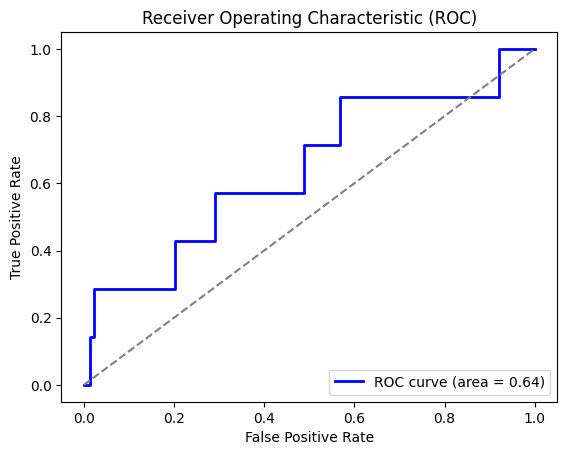

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()


## SVM

SVM & GridSearch

In [ ]:
# Standardize the features
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize SMOTE
smote = SMOTE(random_state=42)
# Apply SMOTE to training data
X_resampled, y_resampled = smote.fit_resample(X_train_val_scaled, y_train)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'gamma': [0.01, 0.1, 1, 'scale', 'auto'],
    'kernel': ['rbf', 'poly'],
    'class_weight': ['balanced', {0: 1, 1: 10}]
}

# Initialize the SVM model
svm_model = SVC(probability=True, random_state=42)

# Grid search for hyperparameter tuning
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=3)
grid_search.fit(X_resampled, y_resampled)

# Output the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best AUC Score:", grid_search.best_score_)

# Use the best estimator for testing
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print("Test Set AUC:", roc_auc)

SVM with manually selecting the parameters

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.63      0.77       878
           1       0.00      0.00      0.00         4

    accuracy                           0.63       882
   macro avg       0.50      0.32      0.39       882
weighted avg       0.99      0.63      0.77       882

Test Set AUC: 0.3670273348519362


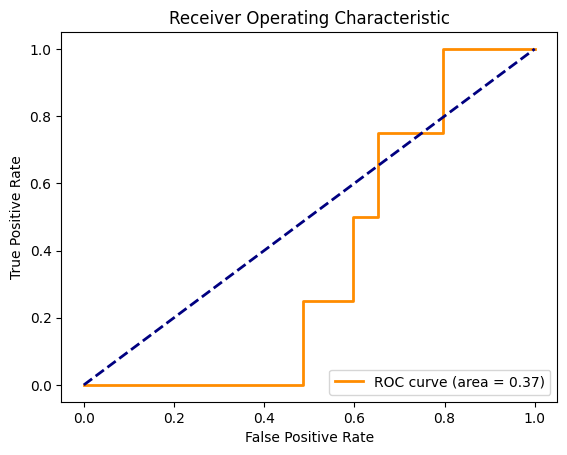

In [352]:
# Standardize the features
scaler = MinMaxScaler()
X_train_val_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize SMOTE
smote = SMOTE(random_state=42)
# Apply SMOTE to training data
X_resampled, y_resampled = smote.fit_resample(X_train_val_scaled, y_train)

# # SMOTE for oversampling the training data
# smote_enn = SMOTEENN(random_state=42)
# X_resampled, y_resampled = smote_enn.fit_resample(X_train_val_scaled, y_train_val)

# Train the SVM model
svm_model = SVC(kernel='rbf', class_weight="balanced", gamma='auto',probability=True, random_state=42)
svm_model.fit(X_resampled, y_resampled)

# Evaluate on the test set
y_pred = svm_model.predict(X_test_scaled)
y_prob = svm_model.predict_proba(X_test_scaled)[:, 1]

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print("Test Set AUC:", roc_auc)

# Plot ROC Curve (optional)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## XGBoost Model

### Perform Recursive Feature Elimination with Cross-Validation (RFECV) to find the best variables

In [54]:
# Base parameters for XGBClassifier
base_params = {
    'objective': 'binary:logistic',
    'colsample_bytree': 0.8,  # Feature subsampling
    'subsample': 0.8,         # Row subsampling
    'eval_metric': 'auc',
    'alpha': 5,              # L1 regularization
    'gamma': 5,              # Minimum loss reduction
    'max_depth': 3,
    'learning_rate': 0.09,
    'n_estimators': 100
}

# Initialize the XGBClassifier
rfe_model = XGBClassifier(**base_params)

# Perform RFE for feature selection
rfe = RFE(
    estimator=rfe_model,
    n_features_to_select=50,  # Select exactly X features
    step=1  # Remove one feature at a time
)

# Fit RFE to X_train
rfe.fit(X_train, y_train)

# Get selected feature names
selected_features = X_train.columns[rfe.support_]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"Selected Features (RFE): {selected_features.tolist()}")
print(f"Number of features selected: {len(selected_features)}")

/home/codespace/.python/current/lib/python3.12/site-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=50 > n_features=44. There will be no feature selection and all features will be kept.
  warnings.warn(


Selected Features (RFE): ['TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1', 'Sprints-1', 'Mins-1', 'TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', 'ACC_Rel-1', 'DEC_Rel-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3', 'DEC-3', 'Sprints-3', 'Mins-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7', 'DEC-7', 'Sprints-7', 'Mins-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21', 'DEC-21', 'Sprints-21', 'Mins-21', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR', '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR', 'DEC_ACWR', 'DEC_MSWR']
Number of features selected: 44


### Grid Search XGBoost

In [55]:
# Updated base parameters with added regularization
base_params_xgboost = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'subsample': 0.8,        
    'colsample_bytree': 0.8 
}

# Expanded parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.07, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [200, 300, 400],
    'scale_pos_weight': [10,12,15],
    'alpha': [0, 5],
    'gamma': [0, 5],
}

# scaler = StandardScaler()
# X_train_selected = scaler.fit_transform(X_train_selected)
# X_test_selected = scaler.transform(X_test_selected)

model = XGBClassifier(**base_params_xgboost)

# Stratified K-Fold Cross-Validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',  # Optimize for ROC-AUC
    cv=stratified_cv,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV on the training dataset
grid_search.fit(X_train_selected, y_train)

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_roc_auc = grid_search.best_score_

# Print best results
print(f"Best ROC-AUC (Grid Search): {best_roc_auc:.4f}")
print(f"Best Parameters: {best_params}")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


/home/codespace/.local/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best ROC-AUC (Grid Search): 1.0000
Best Parameters: {'alpha': 0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 400, 'scale_pos_weight': 12}


### Train the model with the best parameters

In [84]:
base_params_xgboost = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'subsample': 0.8,        
    'colsample_bytree': 0.8 
}

param_grid = {
   'learning_rate': 0.05,  # Explore smaller learning rates
   'max_depth': 5,             # Test broader depth values
   'n_estimators': 300,     # Include larger estimators
   'scale_pos_weight': 12,
   'alpha': 0,  # L1 regularization
   'gamma': 0,  # Minimum loss reduction
}


# Train the model with the best parameters from the grid search
# final_model = XGBClassifier(
#     **base_params_xgboost,
#     **param_grid,
# )

# Train the model with manually selected parameters
final_model = XGBClassifier(
    **base_params_xgboost,
    **param_grid,
)

# Train
final_model.fit(X_train_selected,
                y_train,
                verbose=True
)

# Predict class labels (0 or 1) on the test set
y_pred_probs = final_model.predict_proba(X_test_selected)[:, 1]
# Apply custom threshold
threshold = 0.45
y_pred = (y_pred_probs >= threshold).astype(int)
test_roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f"Final Test ROC-AUC: {test_roc_auc:.4f}")

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Final Test ROC-AUC: 0.6243
Accuracy: 0.9711
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Confusion Matrix:
[[673  13]
 [  7   0]]


### Prepare the data to export in excel

In [53]:
X_test = X_test_selected.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
extra_cols_test = extra_cols_test.reset_index(drop=True)

Categorize the percentages into levels of risk

In [ ]:
def categorize_risk(percentage):
    if percentage < 40:
        return 'Low Risk'
    elif 40 <= percentage < 70:
        return 'Medium Risk'
    else:
        return 'High Risk'

Create a df to later convert to excel and export

In [56]:
# Evaluate the best model on the test set
y_probs = final_model.predict_proba(X_test_selected)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_probs)

print(f"Test ROC-AUC: {test_roc_auc:.4f}")

# Convert the probabilities of injury risk (Class 1) to percentages
injury_risk_percentage = y_probs * 100

# Categorize the injury risk percentages
risk_levels = [categorize_risk(percentage) for percentage in injury_risk_percentage]

# Create the `results` DataFrame with only relevant metrics and calculated values
results = pd.DataFrame({
    'Player_ID': extra_cols_test['PlayerID'],
    'Date': extra_cols_test['DATE'], # Add player IDs
    'Actual_Label': y_test,  # Add actual labels
    '%': injury_risk_percentage,
    'Risk_Level': risk_levels
}).join(X_test[['TD-7', '>25-7', 'ACC-7', 'DEC-7', 'Sprints-7']])  # Add only relevant metrics

Test ROC-AUC: 0.7844


In [207]:
# Define risk level colors
color_mapping = {
    'High Risk': 'FF9999',  # Light Red
    'Medium Risk': 'FFFF99',  # Light Yellow
    'Low Risk': '99FF99'  # Light Green
}

# file_path_export = '/content/drive/MyDrive/WATFORD FC/Datos GPS/results.xlsx'
file_path_export = 'results.xlsx'

wb = Workbook()

# Write `results` to the first sheet
ws = wb.active
ws.title = "Injury Risk Results"
for r_idx, row in enumerate(dataframe_to_rows(results, index=True, header=True), start=1):
    for c_idx, value in enumerate(row, start=1):
        ws.cell(row=r_idx, column=c_idx, value=value)

# Conditional formatting for `results`
risk_level_col_idx = list(results.columns).index("Risk_Level") + 2
for row in ws.iter_rows(min_row=2, max_row=ws.max_row, min_col=risk_level_col_idx, max_col=risk_level_col_idx):
    for cell in row:
        risk_level = cell.value
        if risk_level in color_mapping:
            cell.fill = PatternFill(start_color=color_mapping[risk_level], end_color=color_mapping[risk_level], fill_type="solid")

# Save the workbook
wb.save(file_path_export)

## Mutual Info Regression formula (excluded for now)

In [ ]:
from sklearn.feature_selection import mutual_info_regression
import numpy as np

def mrmr_manual_regression(X, y, num_features):
    selected_features = []
    remaining_features = list(range(X.shape[1]))
    
    # Calculate mutual information for relevance (regression)
    relevance = mutual_info_regression(X, y)
    
    for _ in range(num_features):
        scores = []
        for feature in remaining_features:
            # Calculate redundancy with already selected features
            redundancy = np.mean([mutual_info_regression(X[:, feature].reshape(-1, 1), X[:, sel]) 
                                  for sel in selected_features]) if selected_features else 0
            
            # mRMR score = relevance - redundancy
            score = relevance[feature] - redundancy
            scores.append((feature, score))
        
        # Select the feature with the maximum score
        best_feature = max(scores, key=lambda x: x[1])[0]
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
    
    return selected_features

selected_features_indexes = mrmr_manual_regression(X.values, y.values, 8)

feature_names = X.columns  # Assuming X is a pandas DataFrame
selected_feature_names = [feature_names[i] for i in selected_features_indexes]

print("Selected Features:", selected_feature_names)

X = X[selected_feature_names]